In [1]:
# This notebook analyzes cookies from crawl NL
# (Run with Python 3.6.1 |Anaconda 4.4.0 )

# Th# This notebook analyzes cookies from crawl NL
# (Run with Python 3.6.1 |Anaconda 4.4.0 )

# The crawl includes 1 vantage points and top 1000 websites (no DNT).
# The aim is to understanding cookie-variations well enough to design a good country-cookie-metric.
# (E.g., one site, cookie variations for site based on vantage, and between sites, top-3rd parties, ...)
# (Later, this metric will be linked with site and country characteristics in a regression model.)

%pylab inline --no-import-all 
import pandas as pd
import sqlite3
from numpy import nan
from time import time
from glob import glob
from datetime import datetime
import numpy as np
#from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from tldextract import extract as tldextract  # pip install tldextract
DPI = 120  # used for graphs. check at: http://www.infobyip.com/detectmonitordpi.php

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Two functions that Hadi had to extract domains 

#Function to remove the http, https of site_url
def strip_site(site):
    """Removes leading http:// or https:// and trailing '/'"""
    site = site.lower()
    if site.startswith('http'):
        site = site.replace('https://', '').replace('http://', '')
    if site.endswith('/'):
        site = site[:-1]
    return site

#Function to strip and extract the domains of site_url
def extract_domain(site):
    """Returns domain+tld from a full domain"""
    site = strip_site(site)  # just to be sure
    ext = tldextract(site)
    ret = ".".join([ss for ss in ext[-2:] if ss])
    # In case of gov.ie, or IPs, our 'ret' works better than 'ext.registered_domain'
    return ret

def extract_tld(site):
    """Returns domain+tld from a full domain"""
    site = strip_site(site)  # just to be sure
    ext = tldextract(site)
    ret = ".".join([ss for ss in ext[-1:] if ss])
    # In case of gov.ie, or IPs, our 'ret' works better than 'ext.registered_domain'
    return ret

#Function to extract the domains of host
def extract_host(host):
    """Returns domain+tld from a full domain"""
    ext = tldextract(host)
    ret = ".".join([ss for ss in ext[-2:] if ss])
    return ret


### Banners DE

In [65]:
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-DE\\crawl-data.sqlite')
banner_DE=pd.read_sql_query("""SELECT b.visit_id, url, text,  count(css_selector) m,
                    min(pos_x) x, min(pos_y) y, max(size_w) w, 
                    max(size_h) h 
                    FROM cookie_banners b LEFT JOIN site_visits s ON s.visit_id = b.visit_id 
                    GROUP BY b.visit_id""", con)
#banner_DE
banner_DE.rename(columns={'url':'site_url'}, inplace=True)
banner_DE['site_url']=banner_DE['site_url'].apply(extract_domain)
banner_DE['TLD']= banner_DE.site_url.apply(extract_tld)
banner_DE['VP']= 'DE'
banner_DE['notice_length']=banner_DE.text.str.len()
banner_DE['banner_size']=(banner_DE.w*banner_DE.h)
banner_DE.sort_values(ascending=False, by='notice_length')
banner_DE.head()

,visit_id,site_url,text,m,x,y,w,h,TLD,VP,notice_length,banner_size
0,1,hidemyass.com,\n \n \n We use cookies to ensure you...,1,0,0,1353,78.000000,com,DE,135,105534.000000
1,2,google.de,Hinweise zum Datenschutz bei Google._Ihg{backg...,1,0,520,1366,96.000000,de,DE,1831,131136.000000
2,3,netflix.com,"Netflix uses cookies for personalization, to c...",1,0,0,1353,54.000000,com,DE,380,73062.000000
3,4,microsoft.com,"Diese Website verwendet Cookies für Analysen,...",2,0,0,1353,71.500000,com,DE,192,96739.500000
4,5,facebook.com,"RemoveTo help personalize content, tailor and ...",1,0,0,1353,52.166672,com,DE,292,70581.506882


In [24]:
#Descriptive stats notice length and banner size
print(banner_DE.notice_length.describe())
print(banner_DE.banner_size.describe())

count       56.000000
mean       738.196429
std       1719.433918
min          0.000000
25%        135.750000
50%        197.500000
75%        485.000000
max      11819.000000
Name: notice_length, dtype: float64
count        56.000000
mean     149942.168315
std      196952.884496
min           0.000000
25%       53577.375000
50%       82533.000000
75%      131136.000000
max      943041.000000
Name: banner_size, dtype: float64


In [39]:
#descriptibe stat notice_length per tld
n_d=banner_DE.groupby('TLD')['notice_length'].describe()
n_d

,count,mean,std,min,25%,50%,75%,max
TLD,,,,,,,,
co.uk,6.0,411.666667,702.318067,0.0,75.0,154.0,250.25,1831.0
com,27.0,235.037037,158.234607,0.0,145.5,192.0,297.00,668.0
de,7.0,876.714286,911.076966,78.0,140.0,231.0,1831.00,1886.0
io,1.0,136.000000,NaN,136.0,136.0,136.0,136.00,136.0
nl,15.0,1750.000000,3061.032156,0.0,31.5,647.0,2547.50,11819.0


In [51]:
#Descriptive stats banner_size per tld
b_d=banner_DE.groupby('TLD')['banner_size'].describe()
b_d
#banner_DE.banner_size.plot(kind='hist')

,count,mean,std,min,25%,50%,75%,max
TLD,,,,,,,,
co.uk,6.0,61616.500000,56447.646823,48.000000,20691.000000,49314.000000,108881.250000,131136.000000
com,27.0,136215.440639,175262.287657,2212.000000,61561.500000,82533.000000,127497.695183,943041.000000
de,7.0,75152.571429,54102.240418,11352.000000,35694.000000,49920.000000,131136.000000,131136.000000
io,1.0,61403.647247,NaN,61403.647247,61403.647247,61403.647247,61403.647247,61403.647247
nl,15.0,250784.925408,273849.956099,0.000000,31860.000000,123210.000000,498437.510742,836424.616516


### Banner NL

In [19]:
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-NL\\crawl-data.sqlite')
banner_NL=pd.read_sql_query("""SELECT b.visit_id, url, text,  count(css_selector) m,
                    min(pos_x) x, min(pos_y) y, max(size_w) w, 
                    max(size_h) h 
                    FROM cookie_banners b LEFT JOIN site_visits s ON s.visit_id = b.visit_id 
                    GROUP BY b.visit_id""", con)
#banner_NL
banner_NL.rename(columns={'url':'site_url'}, inplace=True)
banner_NL['site_url']=banner_NL['site_url'].apply(extract_domain)
banner_NL['TLD']= banner_NL.site_url.apply(extract_tld)
banner_NL['VP']= 'NL'
banner_NL['notice_length']=banner_NL.text.str.len()
banner_NL['banner_size']=(banner_NL.w*banner_DE.h)
banner_NL.sort_values(ascending=False, by='notice_length')
banner_NL.head()

,visit_id,site_url,text,m,x,y,w,h,TLD,VP,notice_length,banner_size
0,1,hidemyass.com,\n \n \n We use cookies to ensure you...,1,0,0,1353,78.000000,com,NL,135,105534.000000
1,2,google.nl,Een privacyherinnering van Google._Ihg{backgro...,1,0,520,1366,96.000000,nl,NL,1832,131136.000000
2,3,netflix.com,"Netflix uses cookies for personalisation, to c...",1,0,0,1353,54.000000,com,NL,380,73062.000000
3,4,microsoft.com,Deze site maakt gebruik van cookies om analys...,2,0,0,1353,71.500000,com,NL,209,96739.500000
4,5,facebook.com,"RemoveTo help personalize content, tailor and ...",1,0,0,1353,52.166672,com,NL,292,70581.506882


In [25]:
#Descriptive stats notice length and banner size
print(banner_NL.notice_length.describe())
print(banner_NL.banner_size.describe())

count       58.000000
mean       726.172414
std       1691.689285
min          0.000000
25%        135.250000
50%        207.500000
75%        546.500000
max      11819.000000
Name: notice_length, dtype: float64
count        56.000000
mean     130706.001680
std      166425.473027
min           0.000000
25%       54627.375000
50%       77797.500000
75%      129888.000000
max      943041.000000
Name: banner_size, dtype: float64


In [40]:
#Descriptive stats notice length per tld
n_n=banner_NL.groupby('TLD')['notice_length'].describe()
n_n

,count,mean,std,min,25%,50%,75%,max
TLD,,,,,,,,
co.uk,7.0,474.142857,662.494636,0.0,76.0,229.0,553.00,1832.0
com,27.0,230.222222,146.360286,0.0,145.5,203.0,285.50,668.0
de,5.0,484.000000,755.501158,78.0,140.0,140.0,230.00,1832.0
io,1.0,136.000000,NaN,136.0,136.0,136.0,136.00,136.0
nl,18.0,1668.166667,2807.031240,0.0,57.0,652.5,1873.25,11819.0


In [52]:
#Descriptive stats banner_size per tld
b_n=banner_NL.groupby('TLD')['banner_size'].describe()
b_n
#banner_NL.banner_size.plot(kind='hist')

,count,mean,std,min,25%,50%,75%,max
TLD,,,,,,,,
co.uk,6.0,102532.000000,102563.732725,16236.0,39744.000000,49524.000000,161058.00,265188.000000
com,26.0,129216.533576,181725.915760,0.0,61561.500000,82533.000000,126843.75,943041.000000
de,5.0,54783.200000,34990.272037,16104.0,43200.000000,44928.000000,58738.00,110946.000000
io,1.0,566907.000000,NaN,566907.0,566907.000000,566907.000000,566907.00,566907.000000
nl,18.0,139105.067840,156256.710793,0.0,58985.161812,102896.121559,131136.00,550896.527527


### Banner BG

In [64]:
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-GB\\crawl-data.sqlite')
banner_BG=pd.read_sql_query("""SELECT b.visit_id, url, text,  count(css_selector) m,
                    min(pos_x) x, min(pos_y) y, max(size_w) w, 
                    max(size_h) h 
                    FROM cookie_banners b LEFT JOIN site_visits s ON s.visit_id = b.visit_id 
                    GROUP BY b.visit_id""", con)
#banner_BG
banner_BG.rename(columns={'url':'site_url'}, inplace=True)
banner_BG['site_url']=banner_BG['site_url'].apply(extract_domain)
banner_BG['TLD']= banner_BG.site_url.apply(extract_tld)
banner_BG['VP']= 'BG'
banner_BG['notice_length']=banner_BG.text.str.len()
banner_BG['banner_size']=(banner_BG.w*banner_DE.h)
banner_BG.sort_values(ascending=False, by='notice_length')
banner_BG.head()

,visit_id,site_url,text,m,x,y,w,h,TLD,VP,notice_length,banner_size
0,1,hidemyass.com,\n \n \n We use cookies to ensure you...,1,0,0,1353,78.000000,com,BG,135,105534.000000
1,2,google.cz,Připomenutí od Googlu ohledně ochrany soukromí...,1,0,520,1366,96.000000,cz,BG,1840,131136.000000
2,3,netflix.com,"Netflix uses cookies for personalisation, to c...",1,0,0,1353,54.000000,com,BG,380,73062.000000
3,4,microsoft.com,"This site uses cookies for analytics, persona...",2,0,0,1353,45.500000,com,BG,137,96739.500000
4,5,facebook.com,"RemoveTo help personalise content, tailor and ...",1,0,0,1353,52.166672,com,BG,290,70581.506882


In [27]:
#Descriptive stats notice length and banner size
print(banner_BG.notice_length.describe())
print(banner_BG.banner_size.describe())

count       58.000000
mean       745.206897
std       1692.695719
min          0.000000
25%        136.250000
50%        205.500000
75%        580.250000
max      11819.000000
Name: notice_length, dtype: float64
count        56.000000
mean     125389.598645
std      164826.391389
min           0.000000
25%       54450.000000
50%       66708.753441
75%      129888.000000
max      943041.000000
Name: banner_size, dtype: float64


In [41]:
#Descriptive stats notice length per tld
n_b=banner_BG.groupby('TLD')['notice_length'].describe()
n_b

,count,mean,std,min,25%,50%,75%,max
TLD,,,,,,,,
co.uk,7.0,408.142857,638.581613,74.0,77.5,229.0,279.50,1840.0
com,28.0,280.785714,290.823525,13.0,137.0,197.0,298.75,1561.0
cz,2.0,1840.000000,0.000000,1840.0,1840.0,1840.0,1840.00,1840.0
de,5.0,485.600000,759.069694,78.0,140.0,140.0,230.00,1840.0
io,1.0,136.000000,NaN,136.0,136.0,136.0,136.00,136.0
nl,15.0,1750.600000,3061.050049,0.0,31.5,647.0,2552.00,11819.0


In [53]:
#Descriptive stats banner_size per tld
b_b=banner_BG.groupby('TLD')['banner_size'].describe()
b_b
#banner_BG.banner_size.plot(kind='hist')

,count,mean,std,min,25%,50%,75%,max
TLD,,,,,,,,
co.uk,5.0,112214.400000,111561.788103,16236.0,38016.000000,44928.000000,196704.000000,265188.000000
com,28.0,109914.010821,172802.429752,0.0,54737.375000,61561.500000,98938.125000,943041.000000
cz,2.0,131136.000000,0.000000,131136.0,131136.000000,131136.000000,131136.000000,131136.000000
de,5.0,74106.800000,46364.522808,16104.0,38880.000000,83326.000000,102336.000000,129888.000000
io,1.0,566907.000000,NaN,566907.0,566907.000000,566907.000000,566907.000000,566907.000000
nl,15.0,145562.681408,170665.328770,0.0,59791.323624,96852.243118,146546.401611,550896.527527


### Banner US

In [29]:
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-US\\crawl-data.sqlite')
banner_US=pd.read_sql_query("""SELECT b.visit_id, url, text,  count(css_selector) m,
                    min(pos_x) x, min(pos_y) y, max(size_w) w, 
                    max(size_h) h 
                    FROM cookie_banners b LEFT JOIN site_visits s ON s.visit_id = b.visit_id 
                    GROUP BY b.visit_id""", con)
#banner_US
banner_US.rename(columns={'url':'site_url'}, inplace=True)
banner_US['site_url']=banner_US['site_url'].apply(extract_domain)
banner_US['TLD']= banner_US.site_url.apply(extract_tld)
banner_US['VP']= 'US'
banner_US['notice_length']=banner_US.text.str.len()
banner_US['banner_size']=(banner_US.w*banner_DE.h)
banner_US.sort_values(ascending=False, by='notice_length')
banner_US.head()

,visit_id,site_url,text,m,x,y,w,h,TLD,VP,notice_length,banner_size
0,1,hidemyass.com,\n \n \n We use cookies to ensure you...,1,0,0,1353,78.0,com,US,135,105534.000000
1,6,google.com,Google serves cookies to analyse traffic to th...,1,0,636,1353,61.0,com,US,154,129888.000000
2,27,skype.com,"This site uses cookies for analytics, persona...",3,0,0,1353,45.5,com,US,137,73062.000000
3,30,google.com,Google serves cookies to analyse traffic to th...,1,0,636,1353,61.0,com,US,154,96739.500000
4,32,digicert.com,We use cookies to ensure that we give you the ...,2,0,657,1353,40.5,com,US,164,70581.506882


In [30]:
#Descriptive stats notice length and banner size
print(banner_US.notice_length.describe())
print(banner_US.banner_size.describe())

count       35.000000
mean       793.457143
std       2117.097046
min          0.000000
25%         89.000000
50%        164.000000
75%        260.500000
max      11819.000000
Name: notice_length, dtype: float64
count        35.000000
mean     124804.043250
std      204671.178316
min           0.000000
25%       38848.500000
50%       61561.500000
75%      116358.000000
max      943041.000000
Name: banner_size, dtype: float64


In [42]:
#descriptive stats notice length
n_u=banner_US.groupby('TLD')['notice_length'].describe()
n_u

,count,mean,std,min,25%,50%,75%,max
TLD,,,,,,,,
co.uk,4.0,138.500000,76.387172,74.0,76.25,125.0,187.25,230.0
com,13.0,165.538462,92.031349,0.0,137.00,164.0,203.00,346.0
de,3.0,170.000000,51.961524,140.0,140.00,140.0,185.00,230.0
io,1.0,136.000000,NaN,136.0,136.00,136.0,136.00,136.0
nl,14.0,1744.214286,3176.498076,0.0,18.75,444.5,2720.75,11819.0


In [54]:
#descriptive stats banner size
b_u=banner_US.groupby('TLD')['banner_size'].describe()
b_u
#banner_US.banner_size.plot(kind='hist')

,count,mean,std,min,25%,50%,75%,max
TLD,,,,,,,,
co.uk,4.0,304093.654129,378584.248508,11352.0,45894.00,184299.000000,442498.654129,836424.616516
com,13.0,140698.429922,246191.850181,0.0,61561.50,73062.000000,129888.000000,943041.000000
de,3.0,42636.000000,28046.988288,11484.0,31014.00,50544.000000,58212.000000,65880.000000
io,1.0,61561.500000,NaN,61561.5,61561.50,61561.500000,61561.500000,61561.500000
nl,14.0,80944.129161,79587.432192,7392.0,33630.75,59058.452065,108553.500000,320390.404129


### Combining all data sets

In [32]:
all_banners= pd.concat([banner_US, banner_NL, banner_DE, banner_BG]).reset_index()
all_banners.groupby('VP')['notice_length'].describe()

,count,mean,std,min,25%,50%,75%,max
VP,,,,,,,,
BG,58.0,745.206897,1692.695719,0.0,136.25,205.5,580.25,11819.0
DE,56.0,738.196429,1719.433918,0.0,135.75,197.5,485.00,11819.0
NL,58.0,726.172414,1691.689285,0.0,135.25,207.5,546.50,11819.0
US,35.0,793.457143,2117.097046,0.0,89.00,164.0,260.50,11819.0


In [33]:
all_banners= pd.concat([banner_US, banner_NL, banner_DE, banner_BG]).reset_index()
all_banners.groupby('VP')['banner_size'].describe()

,count,mean,std,min,25%,50%,75%,max
VP,,,,,,,,
BG,56.0,125389.598645,164826.391389,0.0,54450.000,66708.753441,129888.0,943041.0
DE,56.0,149942.168315,196952.884496,0.0,53577.375,82533.000000,131136.0,943041.0
NL,56.0,130706.001680,166425.473027,0.0,54627.375,77797.500000,129888.0,943041.0
US,35.0,124804.043250,204671.178316,0.0,38848.500,61561.500000,116358.0,943041.0


          Count
VP TLD         
BG co.uk    7.0
   com     28.0
   cz       2.0
   de       5.0
   io       1.0
   nl      15.0
DE co.uk    6.0
   com     27.0
   cz       NaN
   de       7.0
   io       1.0
   nl      15.0
NL co.uk    7.0
   com     27.0
   cz       NaN
   de       5.0
   io       1.0
   nl      18.0
US co.uk    4.0
   com     13.0
   cz       NaN
   de       3.0
   io       1.0
   nl      14.0
           Count
count  21.000000
mean    9.857143
std     8.962621
min     1.000000
25%     3.000000
50%     7.000000
75%    15.000000
max    28.000000


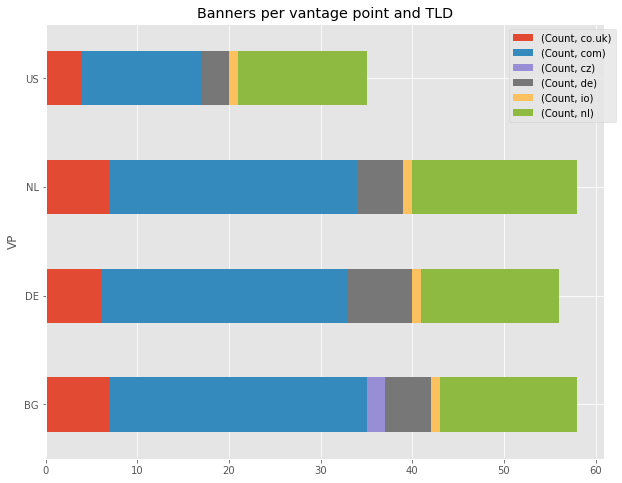

In [61]:
t=all_banners.groupby('VP')['TLD'].value_counts().unstack().stack(dropna=False).reset_index(name="Count").set_index(['VP', 'TLD'])
print(t)
print(t.describe())

t1=t.unstack().plot.barh(stacked=True,figsize=(10, 8),title='Banners per vantage point and TLD', legend=True)
horiz_offset = 1.03
vert_offset = 1.
t1.legend(bbox_to_anchor=(horiz_offset, vert_offset))